In [9]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

This notebook is a guide for the baseline imputation methods of the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [Training](#first-bullet)
* [Imputation](#second-bullet)

### Training <a class="anchor" id="first-bullet"></a>

In [10]:
from data_provider.data_provider import DataProvider
from models.baseline import mean_fill, svd, linear, random_forest

from types import SimpleNamespace
from sklearn.model_selection import train_test_split

In [11]:
args = SimpleNamespace()
args.data = 'bdclim_clean'
args.dataset = 'SequenceMaskDataset'
args.root_path = '../../datasets/'
args.data_path = 'bdclim_safran_2023-2024.nc'
args.has_predictors = False
args.scaler = None
args.batch_size = 1
args.mask_length = 24*7*1
args.mask_proba = 0.5

data_provider = DataProvider(args)

clean_data = data_provider.dataset.data
corrupted_data = data_provider.dataset.corrupted_data

X_train, X_test, y_train, y_test = train_test_split(corrupted_data, clean_data, test_size=0.6, shuffle=False)

optimal rank: 11


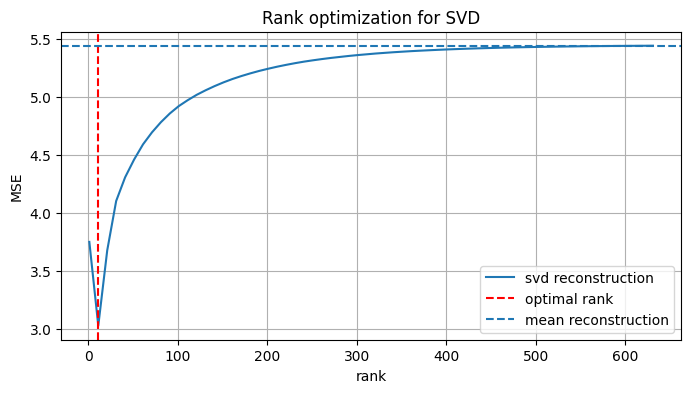

In [12]:
mean_model = mean_fill()

svd_model = svd()
svd_model.train(torch.FloatTensor(X_train), torch.FloatTensor(y_train), verbose=True)

random_forest_model = random_forest()
random_forest_model.train(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

linear_model = linear()
linear_model.train(torch.FloatTensor(X_train), torch.FloatTensor(y_train))

### Imputation <a class="anchor" id="second-bullet"></a>

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [14]:
y_pred_mean = mean_model(torch.FloatTensor(X_test))
MSE_mean = mean_squared_error(y_pred_mean, y_test)
MAE_mean = mean_absolute_error(y_pred_mean, y_test)

y_pred_svd = svd_model.predict(torch.FloatTensor(X_test))
MSE_svd = mean_squared_error(y_pred_svd, y_test)
MAE_svd = mean_absolute_error(y_pred_svd, y_test)

y_pred_random_forest = random_forest_model.predict(torch.FloatTensor(X_test))
MSE_random_forest = mean_squared_error(y_pred_random_forest, y_test)
MAE_random_forest = mean_absolute_error(y_pred_random_forest, y_test)

y_pred_linear = linear_model.predict(torch.FloatTensor(X_test))
MSE_linear = mean_squared_error(y_pred_linear, y_test)
MAE_linear = mean_absolute_error(y_pred_linear, y_test)

metrics = pd.DataFrame({'Mean': [MSE_mean],'SVD': [MSE_svd],'Random forest': [MSE_random_forest],'Linear regression': [MSE_linear]})
metrics.index = ['MSE']
metrics.loc['MAE'] = [MAE_mean, MAE_svd, MAE_random_forest, MAE_linear]

display(metrics)

,Mean,SVD,Random forest,Linear regression
MSE,26.789077,2.516689,5.360751,1.869811
MAE,2.633504,0.728678,1.068692,0.655401


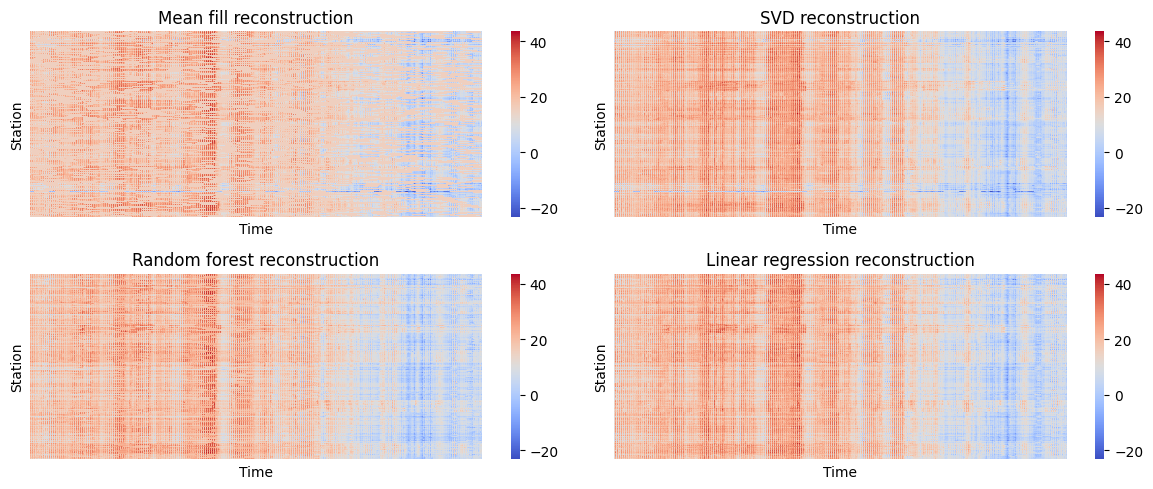

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5))
sns.heatmap(y_pred_mean.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0,0])
ax[0,0].set_title("Mean fill reconstruction")
ax[0,0].set_xlabel("Time")
ax[0,0].set_ylabel("Station")
sns.heatmap(y_pred_svd.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0,1])
ax[0,1].set_title("SVD reconstruction")
ax[0,1].set_xlabel("Time")
ax[0,1].set_ylabel("Station")
sns.heatmap(y_pred_random_forest.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1,0])
ax[1,0].set_title("Random forest reconstruction")
ax[1,0].set_xlabel("Time")
ax[1,0].set_ylabel("Station")
sns.heatmap(y_pred_linear.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[1,1])
ax[1,1].set_title("Linear regression reconstruction")
ax[1,1].set_xlabel("Time")
ax[1,1].set_ylabel("Station")
plt.tight_layout()
plt.show()

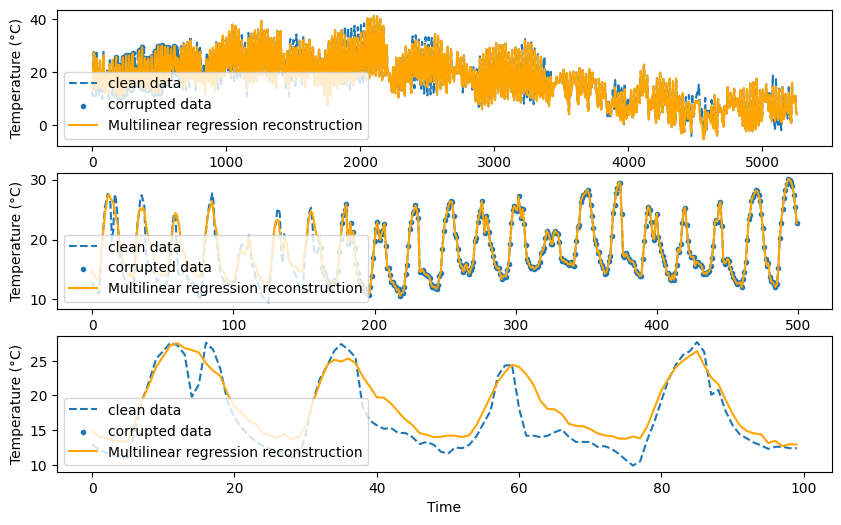

In [16]:
random_station = np.random.choice(np.arange(0, X_test.shape[1]))

fig, ax = plt.subplots(3, 1, figsize=(10, 6))
ax[0].plot(y_test[:,random_station], label='clean data', linestyle='--')
ax[0].scatter(np.arange(0, X_test.shape[0])[:1000], X_test[:,random_station][:1000], label='corrupted data', marker='.')
ax[0].plot(y_pred_linear[:,random_station], label='Multilinear regression reconstruction', color='orange')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Temperature (°C)')
ax[0].legend(loc='lower left')
ax[1].plot(y_test[:500,random_station], label='clean data', linestyle='--')
ax[1].scatter(np.arange(0, X_test.shape[0])[:500], X_test[:500,random_station], label='corrupted data', marker='.')
ax[1].plot(y_pred_linear[:500,random_station], label='Multilinear regression reconstruction', color='orange')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Temperature (°C)')
ax[1].legend(loc='lower left')
ax[2].plot(y_test[:100,random_station], label='clean data', linestyle='--')
ax[2].scatter(np.arange(0, X_test.shape[0])[:100], X_test[:100,random_station], label='corrupted data', marker='.')
ax[2].plot(y_pred_linear[:100,random_station], label='Multilinear regression reconstruction', color='orange')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Temperature (°C)')
ax[2].legend(loc='lower left')